# Initial Imports

In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
import sys
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import argparse
import time
import tensorly as tl
from tensorly.decomposition import partial_tucker
from decompositions import cp_decomposition_conv_layer, tucker_decomposition_conv_layer

from VBMF import VBMF

from torch.utils.data import Dataset, DataLoader, random_split

from torch.nn.utils.rnn import pad_sequence

import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
from torchvision.io import read_image
from PIL import Image
import glob
import os

import matplotlib.pyplot as plt
plt.ion()   # interactive mode

import pandas as pd
import numpy as np
from glob import glob
import os, os.path
import matplotlib.pyplot as plt
from numpy import asarray

import sklearn.metrics
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC, SVR

from sksurv.datasets import load_gbsg2
# from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored, concordance_index_ipcw, integrated_brier_score

import itertools
from itertools import *

import datetime
import pickle

import torchtuples as tt
from pycox.models import CoxCC
from pycox.utils import kaplan_meier
from pycox.evaluation import EvalSurv

from ptflops import get_model_complexity_info
import torchprofile

# Define PyTorch Device

In [2]:
# Use GPU if possible
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# ^ Usually cuda:0, but at time of writing all avaliable memory on GPU 0 is in use.

# Use PyTorch as Tensorly Backend
tl.set_backend('pytorch')

# Force CPU Evaluation (Not Recommended)
# device = torch.device("cpu")

# Deserialize MIMIC Dataset

In [3]:
pd.options.display.max_columns = None

ad_patient_df = pd.read_csv("AD_Patient_Manifest.csv")

ad_patient_df.reset_index(drop=True)

ad_patient_df

,PTID,path
0,053_S_1044,patients_csv/053_S_1044.pkl
1,035_S_0204,patients_csv/035_S_0204.pkl
2,027_S_0256,patients_csv/027_S_0256.pkl
3,128_S_0230,patients_csv/128_S_0230.pkl
4,114_S_0173,patients_csv/114_S_0173.pkl
...,...,...
810,029_S_0843,patients_csv/029_S_0843.pkl
811,129_S_1204,patients_csv/129_S_1204.pkl
812,032_S_1169,patients_csv/032_S_1169.pkl
813,099_S_0060,patients_csv/099_S_0060.pkl


In [4]:
# Split MIMIC-IV Dataset into 80-20% for training and testing.
train = ad_patient_df.sample(frac=0.8,random_state=200)
test = ad_patient_df.drop(train.index)

print(len(train))
print(len(test))
# train
# train.iloc[0]

652
163


# Define Dataloaders

### Patient Dataset

In [5]:
# CustomDataset gets ADNI cohorts for a NN.
class Patient_Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.manifest = dataframe
        self.transform = transform # Apply any given transformations.

    def __getitem__(self, index):
        row_entry = self.manifest.iloc[index]['path'] # Get the row (patient) we want to read.
        cohort = pd.read_pickle(row_entry)

        image = Image.open(cohort.iloc[0]['image_path'])
        if self.transform :
            image = self.transform(image)
        
        # For Cox Model, label should be in the tuple: duration, event
        mmse = torch.tensor(cohort.iloc[0]['MMSE'], dtype=torch.float32)
        dx = torch.tensor(cohort.iloc[0]['DX_encoded'], dtype=torch.float32)
        label = (mmse, dx)
        
        demographics = torch.tensor(cohort.iloc[0]['one_hot_vector'], dtype=torch.float32)
    
        time_series = cohort[['Years_bl', 'ADAS11', 'ADAS13', 'ADASQ4']]
        
        # Convert to Tensor
        time_series_tensor = torch.tensor(time_series.values, dtype=torch.float32)
        
        patient = (image, demographics, time_series_tensor)
        
        return patient, label

    def __len__(self):
        return len(self.manifest)

### Patient Dataloader

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
# Will need to be applied by passing in to Dataset constructor!
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match the input size of VGG-16
        torchvision.transforms.Grayscale(num_output_channels=3),
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),  # Convert PIL image to a tensor
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.1537, 0.1537, 0.1537], std=[0.1762, 0.1762, 0.1762]) 
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to match the input size of VGG-16
        torchvision.transforms.Grayscale(num_output_channels=3),
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize(mean=[0.1537, 0.1537, 0.1537], std=[0.1762, 0.1762, 0.1762]) 
    ]),
}

dl_args = dict(batch_size=16, num_workers=4)

# Dataloaders used to iterate through the patients. Patients split 80-20% into train-test loaders.
train_dataset = Patient_Dataset(train, data_transforms['train'])
train_dataset.transform = data_transforms['train']
train_dataloader = DataLoader(train_dataset)

test_dataset = Patient_Dataset(test, data_transforms['test'])
test_dataset.transform = data_transforms['test']
test_dataloader = DataLoader(test_dataset)

dataloaders = {'train': train_dataloader,
              'test': test_dataloader,
              }

i = 0
for patient in dataloaders['train']:
    i = i + 1
    if i > 5:
        break
    print(patient)

[[tensor([[[[-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          ...,
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723]],

         [[-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          ...,
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723]],

         [[-0.8723, -0.8723, -0.8723,  ..., -0.8723, -0.8723, -0.8723],
          [-0.8723, -0.8723,

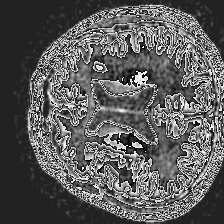

In [7]:
for patient in dataloaders['train']:
    image_tensor = patient[0][0]
    image_tensor = image_tensor.squeeze(dim=0)
#     print(image_tensor.shape)
    image = transforms.ToPILImage()(image_tensor)
    display(image)
    break

### Calculate Mean, Standard Deviation for Dataset Images

In [8]:
# Calculate mean and std
mean = 0.0
std = 0.0
nb_samples = 0

for patient in dataloaders['train']:
    batch_samples = 1  # Batch size (number of images in batch)
    data = patient[0][0]
    data = data.view(batch_samples, data.size(1), -1)  # Reshape to [batch, channels, pixels]
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'Mean: {mean}, Std: {std}')

Mean: tensor([0.1022, 0.1022, 0.1022]), Std: tensor([0.9853, 0.9853, 0.9853])


# Define Independent Models

Independent evaluation of LOS regression performance and mortality classification performance.

### X-Ray Embedder

In [9]:
class ModifiedVGG16Model(torch.nn.Module):
    def __init__(self, num_classes=3):
        super(ModifiedVGG16Model, self).__init__()

        model = models.vgg16(weights='IMAGENET1K_V1')
        self.features = model.features
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.shared = nn.Sequential( # Try simplififying these layers!
            nn.Dropout(0.5),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True))
        
#         # Apply last FC layer for regression.
#         self.regressor = nn.Sequential(
#             nn.Linear(4096, 1))
        
        # Contains the Tail of VGG16 (all 3 FC layers and ReLU, when combined with embedder)
        self.classifier = nn.Sequential(
            nn.Linear(4096, 3))
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.shared(x)
        x = self.classifier(x)

        return x

### Demographics Embedder

In [10]:
class DemographicsEmbedder(torch.nn.Module):
    def __init__(self, model=None):
        super(DemographicsEmbedder, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv1d(1, 10, 3), # Fix input size!
            nn.MaxPool1d(2))
        
        self.shared = nn.Sequential(
            nn.Dropout(),
            nn.Flatten(),
            nn.Linear(140, 70),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(70, 10),
            nn.ReLU(inplace=True))

        # FIXME: Update classifier to handle embedding and Conv1D output.
        self.regressor = nn.Sequential(
            nn.Linear(10, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(10, 3))
        
    def forward(self, demographics):
        x = demographics
        x = x.view(1, 1, 30) # Reshape tensor to [N, C, L] format expected by Conv1D
        x = self.features(x)
        x = self.shared(x)
        los = self.regressor(x)
        mortality = self.classifier(x)
        return (los, mortality)

### Time Series Autoencoder

In [11]:
class Time_Series_Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Time_Series_Autoencoder, self).__init__()
        self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.hidden_to_latent = nn.Linear(hidden_size, latent_size)
        self.latent_to_hidden = nn.Linear(latent_size, hidden_size)
        self.decoder = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.decoder = nn.LSTM(hidden_size, input_size, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, input_size)  # Additional final linear layer

    def forward(self, x, lengths):
        # Pack the padded sequence
        packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        # Encoder
        packed_h, (h, c) = self.encoder(packed_x)
        h = h[-1]  # Get the hidden state from the last layer of the LSTM
        latent = self.hidden_to_latent(h)
        
        # Prepare for decoder
        hidden = self.latent_to_hidden(latent).unsqueeze(0)
        cell = torch.zeros_like(hidden)
        
        # Decoder
        packed_output, _ = self.decoder(packed_x, (hidden, cell))
        
        # Pad the packed sequence
        decoded, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        
        # Apply the final linear layer to map hidden state to input size
        decoded = self.output_layer(decoded)
        
        return latent, decoded
    
    def encode(self, x, lengths):
        with torch.no_grad():
            # Pack the padded sequence
            packed_x = rnn_utils.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            
            # Encoder
            packed_h, (h, c) = self.encoder(packed_x)
            h = h[-1]  # Get the hidden state from the last layer of the LSTM
            latent = self.hidden_to_latent(h)
        
        return latent

# Define Trainer

In [12]:
adni_weights = torch.load('class_weights.pt').to(device)

In [13]:
class Trainer:
    def __init__(self, dataloaders, model, optimizer, model_type):
        self.optimizer = optimizer
        self.model_type = model_type
        self.model = model
        self.model.to(device)
        self.classification_criterion = nn.CrossEntropyLoss(weight=adni_weights)
        self.regression_criterion = nn.MSELoss()
        self.model.train()
        self.train_regression_loss = []
        self.train_classification_loss = []

    def test(self):
        self.model.eval()
        total = 0
        total_time = 0
#         running_regression_loss = 0.0
        running_classification_loss = 0.0
        classification_predictions = []
        classification_labels = []
        
        for i, (entry) in enumerate(dataloaders['train']):
            # Get image, demographics, and label from dataloader and send to device.
            patient = entry[0]
            patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
            
            if self.model_type == "x-ray":
                patient = patient[0].to(device)
            if self.model_type == "demographics":
                patient = patient[1].to(device)
            if self.model_type == "autoencoder":
                patient = patient[2].to(device)
            
            label = entry[1]
            label = (label[0].to(device), label[1].to(device))
            regression_label = label[0].to(device).unsqueeze(1)
            classification_label = label[1].to(device)
            classification_label = classification_label.long()
            
            # Start keeping time, and run model for output.
            t0 = time.time()
            
            output = self.model.forward(patient)
            
            t1 = time.time()
            total_time = total_time + (t1 - t0)
            
            # Calculate item loss
#             model_regression = output[0]
#             model_classification = output[1].float()
            model_classification = output
            
            # Keep track of current classification target
            classification_labels.extend(classification_label.float().to("cpu"))
            # Apply softmax to get probabilities
            probabilities = F.softmax(model_classification, dim=1)
            # Use argmax to get the index of the class with the highest probability
            predicted_class = torch.argmax(probabilities, dim=1)
            # extend output tracker 
            classification_predictions.extend(predicted_class.to("cpu").detach().numpy().tolist())
            
#             regression_loss = self.regression_criterion(model_regression, regression_label)
            classification_loss = self.classification_criterion(model_classification, classification_label)
            
            # Add to running total
#             running_regression_loss += regression_loss.item()
            running_classification_loss += classification_loss.item()
        
        # Get average loss
#         total_regression_loss = running_regression_loss / len(dataloaders['test'])
        total_classification_loss = running_classification_loss / len(dataloaders['test'])
        
        # Print model training time and statistics.
#         print("=== Regression Accuracy ===")
#         print("Mean Squared Error:", total_regression_loss)
#         print("MSE: " + str(total_regression_loss), end=', ')
#         print("=== Classification Accuracy ===")
        classification_labels = [ int(x.item()) for x in classification_labels ]
        classification_predictions = [ round(elem) for elem in classification_predictions ]
#         print("Accuracy Score:", accuracy_score(classification_labels, classification_predictions))
        print("ACC: " + str(accuracy_score(classification_labels, classification_predictions))
                                                          , end=', ')
#         print("Cross Entropy Loss:", total_classification_loss)
        print("CEL:", total_classification_loss)
#         calc_time = float(total_time) / (i + 1)
#         print("Total Prediction Time:", total_time)
#         print('Average Prediction Time: {min}m {sec}s'.format(min=calc_time // 60.0, sec=calc_time % 60.0))
#         print("Total Entries Compared: ", i + 1)
        
        return (total_time, classification_labels, classification_predictions)

    def train(self, epoches=10):
        since = time.time()
#         self.train_regression_loss = []
        self.train_classification_loss = []
        
        for i in range(epoches):
            print("Epoch [" + str(i) + "/" + str(epoches) + "]", end=', ')
            self.train_epoch()
            self.test()
            self.model.eval()
            
        print("Finished fine tuning.")
        time_elapsed = time.time() - since
        print(f'Training complete in  {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        

    def train_batch(self, patient, regression_label, classification_label):
        self.model.train()
        # Not sure why double works fine for forward, but not for backwards. .float() is here to fix this.

        output = self.model.forward(patient)
#         model_regression = output[0]
        model_classification = output
        classification_label = classification_label.squeeze(dim=0).long()
        
#         print("Classification Target:", classification_label)
#         # Apply softmax to get probabilities
#         probabilities = F.softmax(model_classification, dim=1)
#         # Use argmax to get the index of the class with the highest probability
#         predicted_class = torch.argmax(probabilities, dim=1)
#         print("Class Probabilities:  ", probabilities)
#         print("Classification Pred:  ", predicted_class)
#         print("")
        
#         regression_loss = self.regression_criterion(model_regression, regression_label)
        
        classification_loss = self.classification_criterion(model_classification, classification_label)
        
        self.model.zero_grad()
        classification_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
        self.optimizer.step()

    def train_epoch(self):
        for i, (entry) in enumerate(dataloaders['train']):
            # NOTE: Disable model.to(device) for better traceback.
            self.model.to(device)
            patient = entry[0]
            patient = (patient[0].to(device), patient[1].to(device), patient[2].to(device))
            
            if self.model_type == "x-ray":
                patient = patient[0].to(device)
            if self.model_type == "demographics":
                patient = patient[1].to(device)
            if self.model_type == "autoencoder":
                patient = patient[2].to(device)
            
            label = entry[1]
            label = (label[0].to(device), label[1].to(device))
            regression_label = label[0].to(device)
            classification_label = label[1].to(device)
            # Convert input from [1] to [1, 1] size to match input.
            regression_label = regression_label.unsqueeze(1)
            classification_label = classification_label.unsqueeze(1)
            self.train_batch(patient, regression_label, classification_label)
#             if(i % 1000 == 0):
#                 print(i)

# Model Evaluation

Base Models

In [14]:
x_ray_model = ModifiedVGG16Model()
demographics_model = DemographicsEmbedder()
autoencoder = torch.load("TFN_AEC_R1")

In [15]:
print(x_ray_model)

ModifiedVGG16Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddin

### X-Ray Evaluation

In [16]:
# slightly nuclear option
for param in x_ray_model.parameters():
    param.requires_grad = True

In [ ]:
# x_ray_optimizer = torch.optim.Adam(x_ray_model.parameters(), lr=0.000001)
x_ray_optimizer = optim.SGD(x_ray_model.parameters(), lr=0.000001, momentum=0.99, weight_decay=1e-4)
x_ray_scheduler = optim.lr_scheduler.CosineAnnealingLR(x_ray_optimizer, T_max=50)
x_ray_trainer = Trainer(datasets, x_ray_model, x_ray_optimizer, "x-ray")

_, _, _ = x_ray_trainer.test()

x_ray_trainer.train(100)

ACC: 0.294478527607362, CEL: 1.110336011904149
Epoch [0/100], ACC: 0.2822085889570552, CEL: 1.103137698641584
Epoch [1/100], ACC: 0.3374233128834356, CEL: 1.0961690914411486
Epoch [2/100], ACC: 0.4110429447852761, CEL: 1.0910095561501438
Epoch [3/100], ACC: 0.4233128834355828, CEL: 1.087304351885626
Epoch [4/100], ACC: 0.4233128834355828, CEL: 1.0849374243818177
Epoch [5/100], ACC: 0.4171779141104294, CEL: 1.0837771292844434
Epoch [6/100], ACC: 0.4171779141104294, CEL: 1.0839102092696113
Epoch [7/100], ACC: 0.4171779141104294, CEL: 1.0851581136873163
Epoch [8/100], ACC: 0.4171779141104294, CEL: 1.087279580853468
Epoch [9/100], ACC: 0.4171779141104294, CEL: 1.090449103548483
Epoch [10/100], ACC: 0.4171779141104294, CEL: 1.0945652255251364
Epoch [11/100], ACC: 0.4171779141104294, CEL: 1.0994572350583924
Epoch [12/100], ACC: 0.4171779141104294, CEL: 1.1050096552796158
Epoch [13/100], 

In [ ]:
demographics_optimizer = torch.optim.Adam(demographics_model.parameters(), lr=0.0001)
demographics_trainer = Trainer(datasets, demographics_model, demographics_optimizer, "demographics")

_, _, _ = demographics_trainer.test()

demographics_trainer.train(20)

# Autoencoder Custom Evaluation

In [ ]:
autoencoder.to(device)

embed_list_train = []
regression_labels_train = []
classification_labels_train = []

for entry in dataloaders['train']:
    patient = entry[0]
    time_series = patient[2].to(device)
    lengths = [len(seq) for seq in time_series]
    embed = autoencoder.encode(time_series, lengths)
    embed_list_train.extend(embed.to("cpu"))
    
    label = entry[1]
    label = (label[0].to(device), label[1].to(device))
    current_regression_label = label[0].to(device)
    current_classification_label = label[1].to(device)

    # Add each label to list keeping track of all entries.
    regression_labels_train.extend(current_regression_label.to("cpu"))
    classification_labels_train.extend(current_classification_label.to("cpu"))
    

embed_list_test = []
regression_labels_test = []
classification_labels_test = []

for entry in dataloaders['test']:
    patient = entry[0]
    time_series = patient[2].to(device)
    lengths = [len(seq) for seq in time_series]
    embed = autoencoder.encode(time_series, lengths)
    embed_list_test.extend(embed.to("cpu"))
    
    label = entry[1]
    label = (label[0].to(device), label[1].to(device))
    current_regression_label = label[0].to(device)
    current_classification_label = label[1].to(device)

    # Add each label to list keeping track of all entries.
    regression_labels_test.extend(current_regression_label.to("cpu"))
    classification_labels_test.extend(current_classification_label.to("cpu"))
    
print("Train:")
print(len(embed_list_train))
print(len(regression_labels_train))
print(len(classification_labels_train))
print("Test:")
print(len(embed_list_test))
print(len(regression_labels_test))
print(len(classification_labels_test))

In [ ]:
embed_list_train[0]

In [ ]:
regression_labels_train[0]

In [ ]:
embed_list_train = np.array([x.numpy() for x in embed_list_train])
regression_labels_train = np.array([x.numpy() for x in regression_labels_train])
classification_labels_train = np.array([x.numpy() for x in classification_labels_train])
embed_list_test = np.array([x.numpy() for x in embed_list_test])
regression_labels_test = np.array([x.numpy() for x in regression_labels_test])
classification_labels_test = np.array([x.numpy() for x in classification_labels_test])

### Logistic & SVM Models for Autoencoder

In [ ]:
# Building the logistic regression model 
lrclf = LogisticRegression() 
lrclf.fit(embed_list_train, classification_labels_train) 
  
# Storing the predictions of the linear model 
y_pred_lrclf = lrclf.predict(embed_list_test) 
  
# Evaluating the performance of the linear model 
print('Accuracy : '+str(accuracy_score(classification_labels_test, y_pred_lrclf)))

In [ ]:
# Building the SVM model 
svmclf = SVC() 
svmclf.fit(embed_list_train, classification_labels_train) 
  
# Storing the predictions of the non-linear model 
y_pred_svmclf = svmclf.predict(embed_list_test) 
  
# Evaluating the performance of the non-linear model 
print('Accuracy : '+str(accuracy_score(classification_labels_test, y_pred_svmclf))) 

In [ ]:
# define model
model = SVR()
# fit model on the training dataset
model.fit(embed_list_train, regression_labels_train)
# make prediction on test set
yhat = model.predict(embed_list_test)
# invert transforms so we can calculate errors
# yhat = yhat.reshape((len(yhat), 1))
# yhat = trans_out.inverse_transform(yhat)
# y_test = trans_out.inverse_transform(regression_labels_test)
# calculate error
score = mean_absolute_error(regression_labels_test, yhat)
print(score)